In [20]:
import numpy as np
import math 

from namedview import namedview
from pydrake.systems.framework import (BasicVector,
                                       LeafSystem,
                                       PublishEvent,
                                       AbstractValue,
                                       UnrestrictedUpdateEvent,
                                       WitnessFunctionDirection)

CompassGaitState = namedview('CompassGaitState', ['stance', 'swing', 'stancedot', 'swingdot'])

class CompassGait(LeafSystem):
    def __init__(self, slope, mass_hip):
        LeafSystem.__init__(self)
        
        self.DeclareContinuousState(BasicVector(np.zeros(4)), 2, 2, 0)
        self.DeclareDiscreteState(1)
        
        left_stance = True 
        self.DeclareAbstractState(AbstractValue.Make(left_stance))
        
        self.DeclareVectorOutputPort("minimal", BasicVector(4), self.MinimalStateOut)
        self.DeclareVectorOutputPort("floatingbase", BasicVector(14), self.FloatingBaseStateOut)
        
        self.gravity = 9.81
        self.slope = slope
        
        self.mass_leg = 5
        self.mass_hip = mass_hip
        self.length_leg = 1.0 
        self.center_of_mass_leg = 0.5
        self.distance = self.length_leg - self.center_of_mass_leg
        
        self.collision_witness = self.MakeWitnessFunction(
            "foot_collision", WitnessFunctionDirection.kPositiveThenNonPositive, 
            self.foot_collision, UnrestrictedUpdateEvent(self.collision_dynamics))
        
    def get_toe_position(self, context):
        return context.get_discrete_state(0).GetAtIndex(0)
    
    def set_toe_position(self, context, value):
        context.get_discrete_state(0).get_mutable_value().SetAtIndex(value)
        
    def left_leg_is_stance(self, context):
        return bool(context.get_abstract_state(0));
        
    def foot_collision(self, context):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        collision = 2*self.slope - c.stance - c.swing
        return max(collision, c.swing - c.stance)
    
    def collision_dynamics(self, context, state):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        next_c = CompassGaitState(context.get_mutable_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        cst = math.cos(c.stance)
        csw = math.cos(c.swing)
        hip_angle = c.swing - c.stance
        ch = math.cos(hip_angle)
        sh2 = math.sin(hip_angle / 2)
        sst = math.sin(c.stance)
        ssw = math.sin(c.swing)
        
        M = np.array([[2*m + mh, 0, (m * a + m * l + mh * l) * cst, -m * b * csw], 
                     [0, 2 * m + mh, -(m * a + m * l + mh * l) * sst, m * b * ssw], 
                     [(m * a + m * l + mh * l) * cst, -(m * a + m * l + mh * l) * sst, m * a * a + (m + mh) * l * l,    -m * l * b * c], 
                     [-m * b * csw, m * b * ssw, -m * l * b * ch, m * b * b]])
        J = np.array([[1, 0, l * cst,  -l * csw], 
                      [0, 1, -l * sst, l * ssw]])
        
        V_pre = np.array([0, 0, c.stancedot, c.swingdot])
        M_inv = np.linalg.inv(M)
    
        V_post = V_pre - M_inv * np.transpose(J) * (J * M_inv * np.linalg.inv(np.transpose(J))) * J * V_pre

        next_c.stance = c.swing
        next_c.swing = c.stance
        next_c.stancedot = V_post[3]
        next_c.swingdot = V_post[2]
        
        self.set_toe_position(self.get_toe_position(context) - 2 * l * sh2, state)
        state.set_left_leg_is_stance(not self.left_leg_is_stance(context))
        
    def MinimalStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = output.SetFromVector(x)
        
    def FloatingBaseStateOut(self, context, output):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        toe = self.get_toe_position(context)
        left_stance = self.left_leg_is_stance(context)
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        cs = math.cos(self.slope)
        ss = math.sin(self.slope)
        cst = math.cos(c.stance)
        csw = math.cos(c.swing)
        hip_angle = c.swing - c.stance
        ch = math.cos(hip_angle)
        sst = math.sin(c.stance)
        ssw = math.sin(c.swing)
        
        output.SetAtIndex(0, toe * cs + l * sst)
        output.SetAtIndex(1, 0)
        output.SetAtIndex(2, -toe * ss + l * cst)
        
        left = c.stance if left_stance else c.swing 
        right = c.swing if left_stance else c.stance
        
        output.SetAtIndex(3, 0)
        output.SetAtIndex(4, left)
        output.SetAtIndex(5, 0)
        
        output.SetAtIndex(6, right - left)
        
        output.SetAtIndex(7, c.stancedot * l * cst)
        output.SetAtIndex(8, 0)
        output.SetAtIndex(9, -c.stancedot * l * sst)
        
        leftdot = c.stancedot if left_stance else c.swingdot
        rightdot = c.swingdot if left_stance else c.stancedot 

        output.SetAtIndex(10, 0)
        output.SetAtIndex(11, leftdot)
        output.SetAtIndex(12, 0)
        
        output.SetAtIndex(13, rightdot - leftdot)
        
    def DynamicsBiasTerm(self, context):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        g = self.gravity
        s_diff =  math.sin(c.stance - c.swing)
        sst = math.sin(c.stance)
        ssw = math.sin(c.swing)
        vst = c.stancedot
        vsw = c.swingdot
        
        bias = np.array([-m * l * b * vsw * vsw * s_diff - (mh * l + m * (a + l)) * g * sst, 
                         m * l * b * vst * vst * s_diff + m * b * g * ssw])
        
        return bias 
        
    def MassMatrix(self, context):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        
        m = self.mass_leg
        mh = self.mass_hip
        a = self.distance
        b = self.center_of_mass_leg
        l = self.length_leg
        c_diff = math.cos(c.swing - c.stance)
        
        M = np.array([[mh * l * l + m * (l * l + a * a), -m * l * b * c_diff], 
                      [-m * l * b * c_diff, m * b * b]])
        
        return M 
        
    def DoGetWitnessFunctions(self, context):
        return [self.collision_witness]

    def DoCalcTimeDerivatives(self, context, derivatives):
        c = CompassGaitState(context.get_continuous_state_vector().CopyToVector())
        cdot = CompassGaitState(np.zeros(4))
        cdot[0:2] = c[2:4]
        
        M = self.MassMatrix(context)
        bias = self.DynamicsBiasTerm(context)
        
        a = -np.linalg.inv(M) * bias 
        
        cdot.stancedot = a[0]
        cdot.swingdot = a[1]

        derivatives.get_mutable_vector().SetFromVector(cdot[:])

ValueError: setting an array element with a sequence.

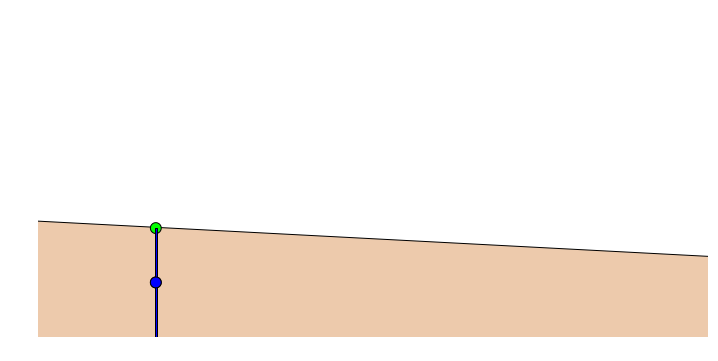

In [21]:
import argparse
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (Box,
                         DiagramBuilder,
                         FindResourceOrThrow,
                         FloatingBaseType,
                         Isometry3,
                         RigidBodyTree,
                         RigidBodyPlant,
                         SignalLogger,
                         Simulator,
                         VisualElement)
# from pydrake.examples.compass_gait import (CompassGait, CompassGaitParams)
from underactuated import (PlanarRigidBodyVisualizer)
from IPython.display import HTML

tree = RigidBodyTree("CompassGait.urdf", FloatingBaseType.kRollPitchYaw)

# tree = RigidBodyTree(FindResourceOrThrow(
#                         "drake/examples/compass_gait/CompassGait.urdf"),
#                      FloatingBaseType.kRollPitchYaw)

# params = CompassGaitParams()

slope = 0.0525 
mass_hip = 10 

R = np.identity(3)
R[0, 0] = math.cos(slope)
R[0, 2] = math.sin(slope)
R[2, 0] = -math.sin(slope)
R[2, 2] = math.cos(slope)
X = Isometry3(rotation=R, translation=[0, 0, -5.])
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.compile()

builder = DiagramBuilder()
# compass_gait = builder.AddSystem(RigidBodyPlant(tree))

compass_gait = builder.AddSystem(CompassGait(slope, mass_hip))

logger = builder.AddSystem(SignalLogger(14))
logger.DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(compass_gait.get_output_port(1), logger.get_input_port(0))

vis = PlanarRigidBodyVisualizer(tree, xlim=[-1., 5.], ylim=[-1., 2.], figsize_multiplier=2)

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)

context = simulator.get_mutable_context()
diagram.Publish(context)  # draw once to get the window open
context.SetAccuracy(1e-4)
context.SetContinuousState([0., 0., 0.4, -2.])

simulator.StepTo(5.0)

ani = vis.animate(logger, 60, repeat=True)
plt.close(vis.fig)
HTML(ani.to_html5_video())